In [1]:
from google.colab import drive
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import numpy as np
from functools import reduce
from datetime import datetime

In [2]:
from tensorflow.keras import layers, Model
from keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow as tf

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

In [5]:
def visualize_pair(pair, pred=None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  fig.suptitle('Sim: {}'.format(pair['Sim']), size=16)
  ax1.imshow(load_img(img_dir + pair['Image1']))
  ax1.set_axis_off()
  ax2.imshow(load_img(img_dir + pair['Image2']))
  ax2.set_axis_off()
  plt.show()

In [6]:
def pairs(df):
  def f(row):
    return [[row['Image'], df[df['Class']==row['Class']].sample(n=1).iloc[0,0], 0],
            [row['Image'], df[df['Class']!=row['Class']].sample(n=1).iloc[0,0], 1]]
  return pd.DataFrame(reduce(lambda x, y: x + y, df.apply(f,axis=1).to_list(), []),
                      columns=['Image1','Image2','Sim'])

In [7]:
def get_celebrities(n_celebrities:int, refactor_class=False):
    df1, df2 = get_max_aparicions(get_identities(), n_celebrities)
    #df.reset_index(inplace=True, drop=True)
    if refactor_class:
        df1 = refactor_identity(df1, 'Identity')
    return df1, df2

def get_max_aparicions(df:pd.DataFrame, n_celebrities:int):
    aparicions_df = df["Identity"].value_counts()
    aparicions_df = aparicions_df.reset_index()
    aparicions_df = aparicions_df.rename(columns={'Identity':'aparicions', 'index':'Identity'})
    aparicions_df = aparicions_df.iloc[:n_celebrities]
    return df[df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True), df[~df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True)

def get_identities():
    identity_df = pd.read_csv("/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/main_img/identity_CelebA.txt", sep=' ', header=None)
    identity_df = identity_df.rename(columns={0:"Image_name", 1:"Identity"})
    return identity_df

def refactor_identity(df, traget_col):
    d = get_dic_index(df, traget_col)
    df["Class"] = df.apply(lambda row: d[row[traget_col]], axis=1)
    return df

def get_dic_index(df, traget_col):
    df = df[traget_col].value_counts()
    dic_index = df.to_dict()
    i = 0
    for c in dic_index:
        dic_index[c] = i
        i += 1
    return dic_index
def get_tvt(df:pd.DataFrame, target_name:str, train_size:int):
    total_classes = df[target_name].nunique()
    n_df_col = df.shape[0]
    df = shuffle(df)
    train_df = df.iloc[:int(n_df_col*train_size)]
    val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
    test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
    while True:
        if train_df[target_name].nunique() == total_classes and val_df[target_name].nunique() == total_classes and test_df[target_name].nunique() == total_classes:
            return train_df, val_df, test_df

        df = shuffle(df)
        train_df = df.iloc[:int(n_df_col*train_size)]
        val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
        test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]

In [8]:
class DataGenerator(Sequence):
  def __init__(self, df, batch_size=32, img_size=(200,200), img_dir= './', shuffle=True):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_dir = img_dir
    self.df = df
    self.indices = self.df.index.tolist()
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.indices) // self.batch_size

  def __getitem__(self, index):
    index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]
    
    X1, X2, y = self.__get_data(batch)
    return [X1, X2], y

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle:
      np.random.shuffle(self.index)

  def __get_data(self, batch):
    X1 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    X2 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    y = np.zeros((self.batch_size,), dtype="float32")
    for i, idx in enumerate(batch):
      X1[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image1'], target_size=self.img_size))
      X2[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image2'], target_size=self.img_size))
      y[i] = self.df.loc[idx,'Sim']
    return X1, X2, y

In [9]:
num_classes = 100
identity_df, rest = get_celebrities(num_classes, refactor_class=True)
identity_df = identity_df[["Image_name", "Class"]].rename(columns={"Image_name": "Image"})
identity_df.head()

,Image,Class
0,000001.jpg,99
1,000096.jpg,14
2,000116.jpg,11
3,000150.jpg,12
4,000404.jpg,99


In [10]:
pairsTest = pd.read_csv("/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/2022-11-21 20h 05m Preds_test_8.txt")
img_dir = "/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/main_img/"
img_size = (178,218)

In [11]:
identity_df['Image1'] = '000000_nat.jpg'
identity_df['Sim'] = 0
identity_df.rename(columns={'Image':'Image2'}, inplace=True)
identity_df = identity_df[['Image1', 'Image2', 'Sim']]
identity_df

,Image1,Image2,Sim
0,000000_nat.jpg,000001.jpg,0
1,000000_nat.jpg,000096.jpg,0
2,000000_nat.jpg,000116.jpg,0
3,000000_nat.jpg,000150.jpg,0
4,000000_nat.jpg,000404.jpg,0
...,...,...,...
3033,000000_nat.jpg,200678.jpg,0
3034,000000_nat.jpg,200853.jpg,0
3035,000000_nat.jpg,201865.jpg,0
3036,000000_nat.jpg,201873.jpg,0


In [12]:
testGenerator = DataGenerator(identity_df, batch_size=62, img_size=img_size, img_dir=img_dir, shuffle=False)

In [13]:
class EuclideanDLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, x, y):
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [14]:
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )

In [15]:
def loss(margin=1.0):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [16]:
siamese = load_model('/content/drive/My Drive/TFG_Xarxes_neuronals_siameses/Weights/2022-11-21 20h 05m_test_8.best', 
                     custom_objects={'KerasLayer': hub.KerasLayer,
                                     'EuclideanDLayer': EuclideanDLayer,
                                     'contrastive_loss': contrastive_loss})

In [17]:
# siamese.evaluate(testGenerator)

In [18]:
identity_df['Preds'] = siamese.predict(testGenerator)

49/49 [==============================] - 21s 312ms/step


In [19]:
def visualize(pair, to_show=2):
  for i in range(to_show*2):
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
      fig.suptitle('Pred: {}'.format(pair['Preds'].loc[i]), size=16)
      ax1.imshow(load_img(img_dir + pair['Image1'].loc[i]))
      ax1.set_axis_off()
      ax2.imshow(load_img(img_dir + pair['Image2'].loc[i]))
      ax2.set_axis_off()
  plt.show()

In [20]:
identity_df = identity_df.sort_values('Preds').reset_index()
identity_df

,index,Image1,Image2,Sim,Preds
0,2440,000000_nat.jpg,136366.jpg,0,0.071385
1,2556,000000_nat.jpg,144369.jpg,0,0.086399
2,1763,000000_nat.jpg,098826.jpg,0,0.093681
3,677,000000_nat.jpg,039393.jpg,0,0.101919
4,1573,000000_nat.jpg,088152.jpg,0,0.104088
...,...,...,...,...,...
3033,2718,000000_nat.jpg,154733.jpg,0,0.999993
3034,921,000000_nat.jpg,051657.jpg,0,0.999994
3035,160,000000_nat.jpg,011358.jpg,0,0.999994
3036,2378,000000_nat.jpg,133008.jpg,0,0.999995


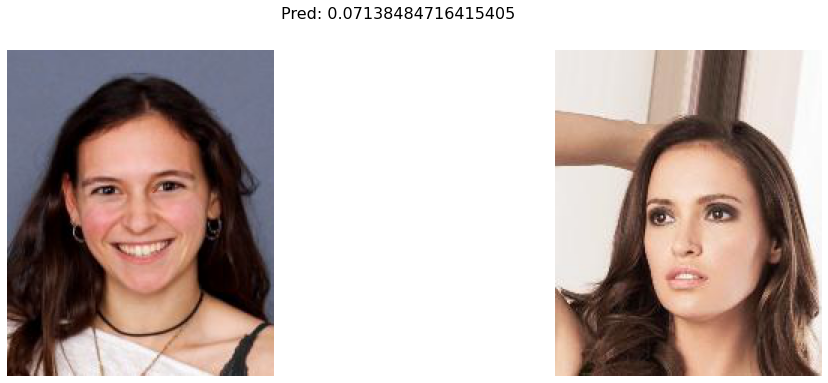

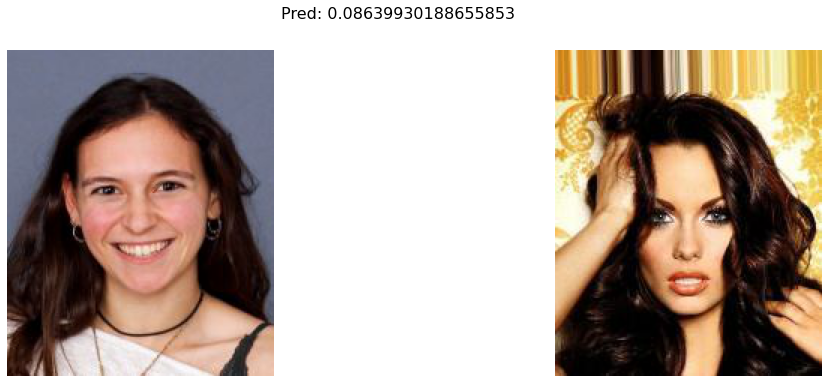

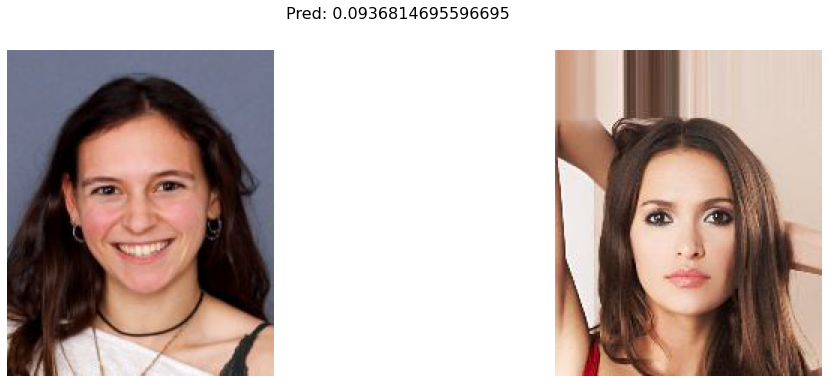

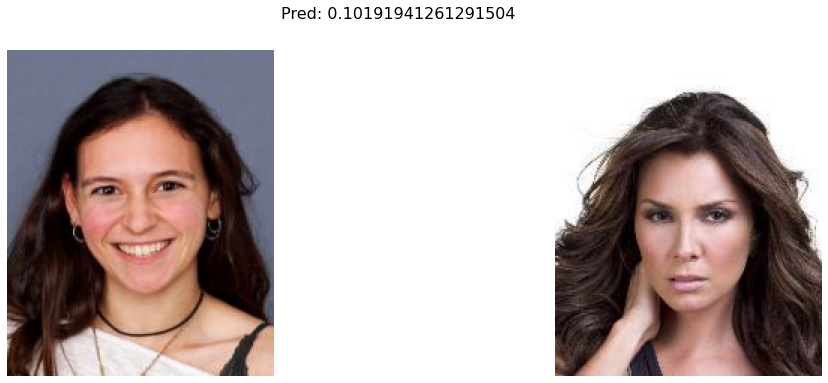

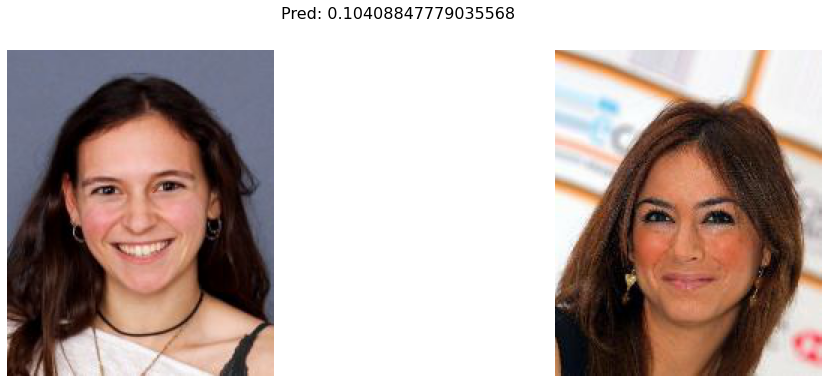

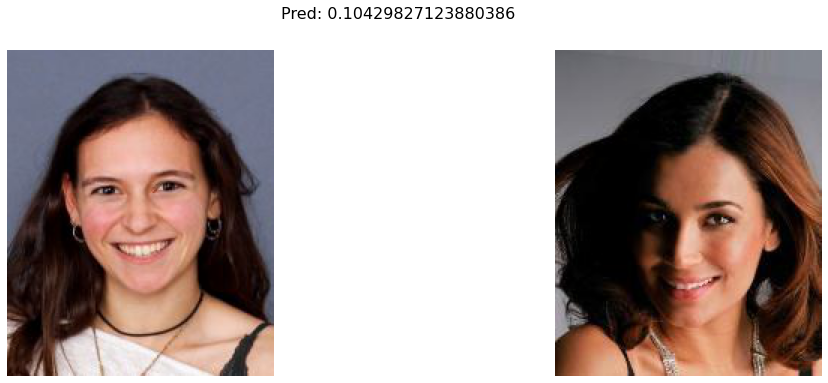

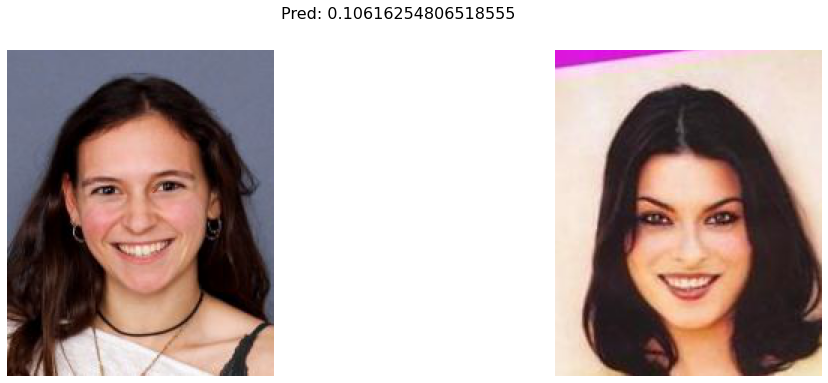

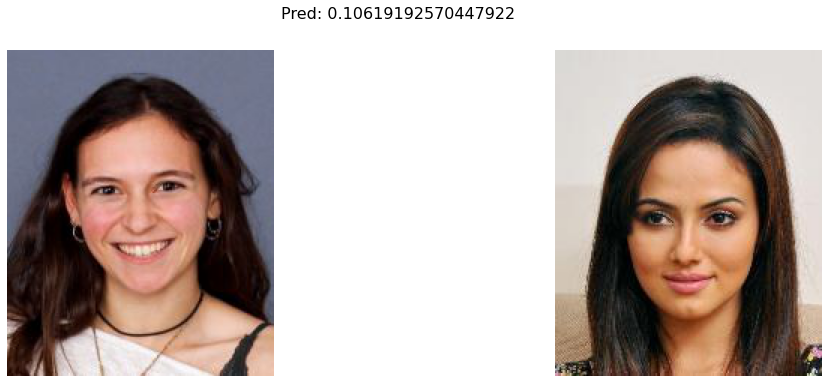

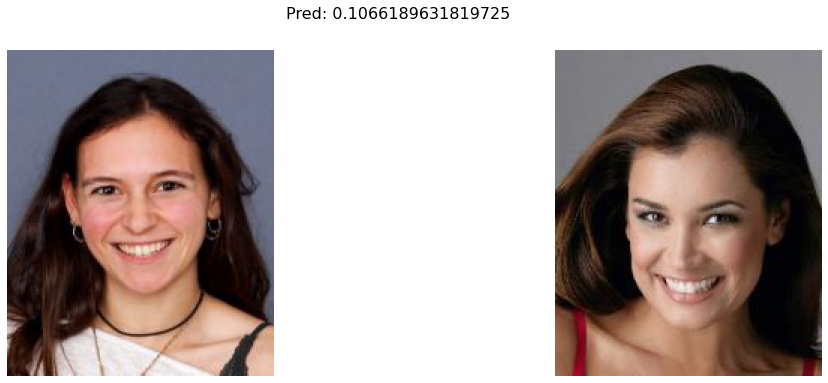

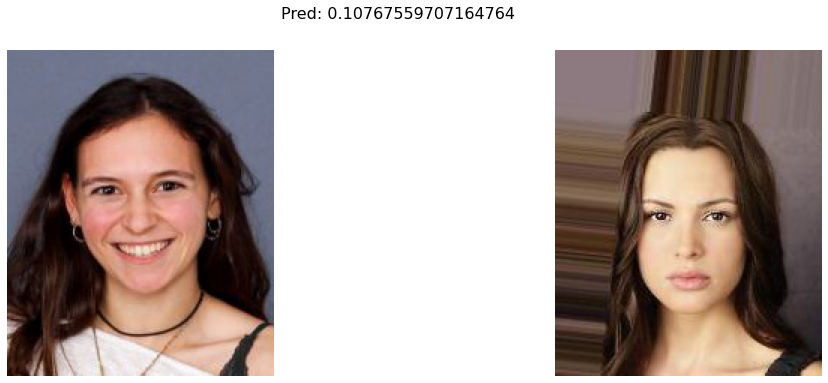

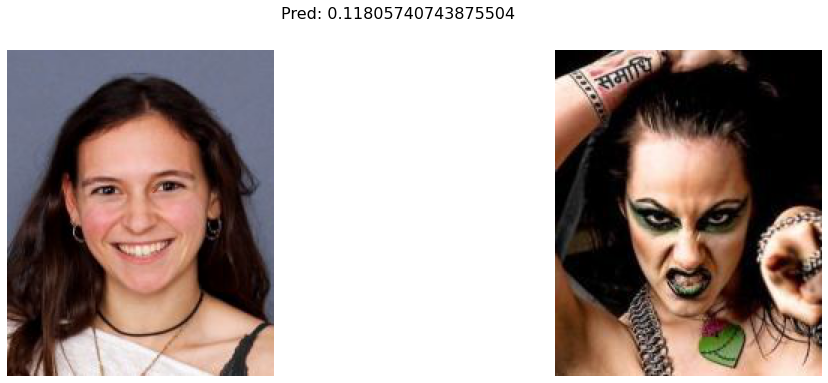

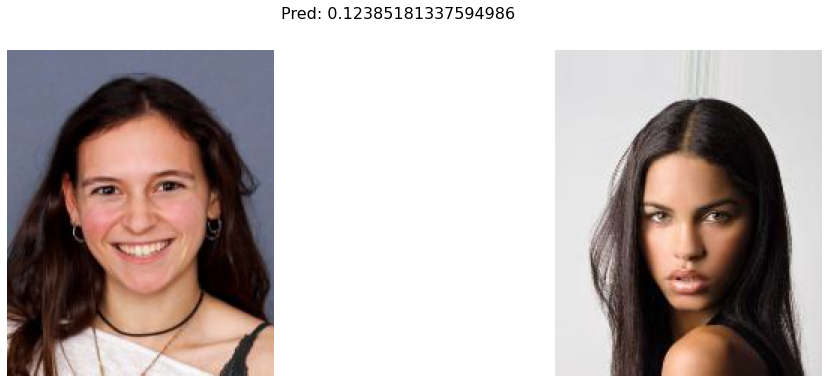

In [21]:
visualize(identity_df, to_show=6)